In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler



In [4]:

OUTPUT_DIR = "/Users/brandon/Documents/projects/synth_data_proj/data/data_outputs"


TARGET = "income"

# Define models to train
MODELS = {
    "LogReg": LogisticRegression(max_iter=500),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

In [5]:
# Load data
train_real = pd.read_csv(os.path.join(OUTPUT_DIR, "train_df.csv"))
holdout = pd.read_csv(os.path.join(OUTPUT_DIR, "holdout_df.csv"))
train_ctgan = pd.read_csv(os.path.join(OUTPUT_DIR, "synthetic_ctgan.csv"))
train_copula = pd.read_csv(os.path.join(OUTPUT_DIR, "synthetic_copula.csv"))

train_tvae = pd.read_csv(os.path.join(OUTPUT_DIR, "synthetic_tvae.csv"))



In [6]:
print("NaNs in TVAE:", train_tvae.isna().sum().sum())
print("Infinite values in TVAE:", np.isinf(train_tvae).sum().sum())
print("TVAE summary stats:\n", train_tvae.describe())


NaNs in TVAE: 0
Infinite values in TVAE: 0
TVAE summary stats:
                 age     workclass         fnlwgt     education  education-num  \
count  10000.000000  10000.000000   10000.000000  10000.000000   10000.000000   
mean      41.071700      3.923800  127564.209700     10.027000       9.864700   
std       14.635928      1.169757   41519.730918      3.823602       2.553673   
min       17.000000      0.000000   13769.000000      0.000000       2.000000   
25%       28.000000      4.000000   97669.000000      8.000000       9.000000   
50%       42.000000      4.000000  120110.000000     11.000000      10.000000   
75%       53.000000      4.000000  155795.500000     12.000000      12.000000   
max       85.000000      7.000000  426044.000000     15.000000      16.000000   

       marital-status  occupation  relationship          race           sex  \
count    10000.000000  10000.0000  10000.000000  10000.000000  10000.000000   
mean         2.549500      8.0596      1.473000 

In [7]:
# Split features and targets
def split_xy(df):
    X = df.drop(columns=[TARGET])
    y = df[TARGET]
    return X, y

X_holdout, y_holdout = split_xy(holdout)
datasets = {
    "Real": split_xy(train_real),
    "CTGAN": split_xy(train_ctgan),
    "Copula": split_xy(train_copula),
    "TVAE": split_xy(train_tvae,)
}


In [8]:
# Create scaled versions for Logistic Regression
scaler = StandardScaler()
scaled_datasets = {}

for name, (X, y) in datasets.items():
    X_scaled = scaler.fit_transform(X)
    scaled_datasets[name] = (X_scaled, y)


In [9]:
# Trainf and evaluate models
results = []
for model_name, model in MODELS.items():
    for data_name in datasets:
        # Use scaled inputs for LogReg, raw for RF
        if model_name == "LogReg":
            X_train, y_train = scaled_datasets[data_name]
            X_holdout_use = scaler.fit_transform(X_holdout)
        else:
            X_train, y_train = datasets[data_name]
            X_holdout_use = X_holdout

        model.fit(X_train, y_train)
        y_pred = model.predict(X_holdout_use)
        y_proba = model.predict_proba(X_holdout_use)[:, 1]

        results.append({
            "Model": model_name,
            "Trained_On": data_name,
            "Accuracy": accuracy_score(y_holdout, y_pred),
            "F1": f1_score(y_holdout, y_pred),
            "AUC": roc_auc_score(y_holdout, y_proba),
             "Precision": precision_score(y_holdout, y_pred),
            "Recall": recall_score(y_holdout, y_pred)
        })


/Users/brandon/Documents/projects/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/brandon/Documents/projects/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/brandon/Documents/projects/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/brandon/Documents/projects/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/brandon/Documents/projec

In [10]:

# Convert results to DF
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(OUTPUT_DIR, "utility_results.csv"), index=False)
print(results_df)

          Model Trained_On  Accuracy        F1       AUC  Precision    Recall
0        LogReg       Real  0.827540  0.563975  0.857467   0.720635  0.463265
1        LogReg      CTGAN  0.814519  0.555621  0.837487   0.656467  0.481633
2        LogReg     Copula  0.778651  0.182396  0.832019   0.823770  0.102551
3        LogReg       TVAE  0.792040  0.523769  0.824203   0.583699  0.475000
4  RandomForest       Real  0.858617  0.684052  0.909621   0.740345  0.635714
5  RandomForest      CTGAN  0.833313  0.612839  0.871170   0.695146  0.547959
6  RandomForest     Copula  0.762191  0.031031  0.714579   0.815789  0.015816
7  RandomForest       TVAE  0.810220  0.616910  0.861700   0.600096  0.634694


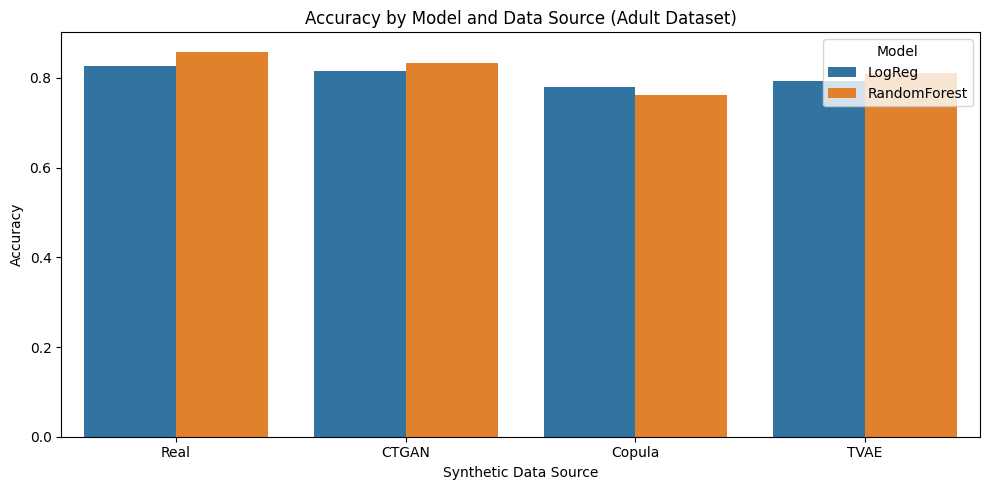

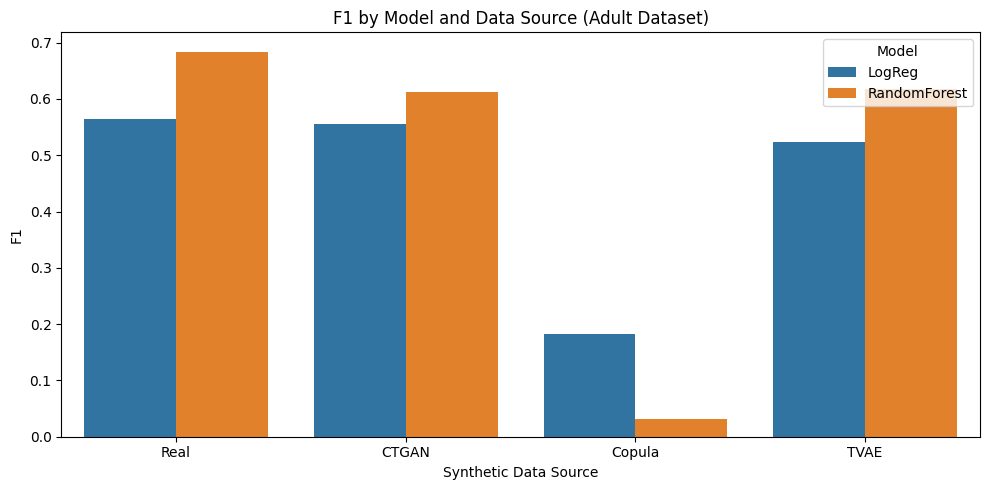

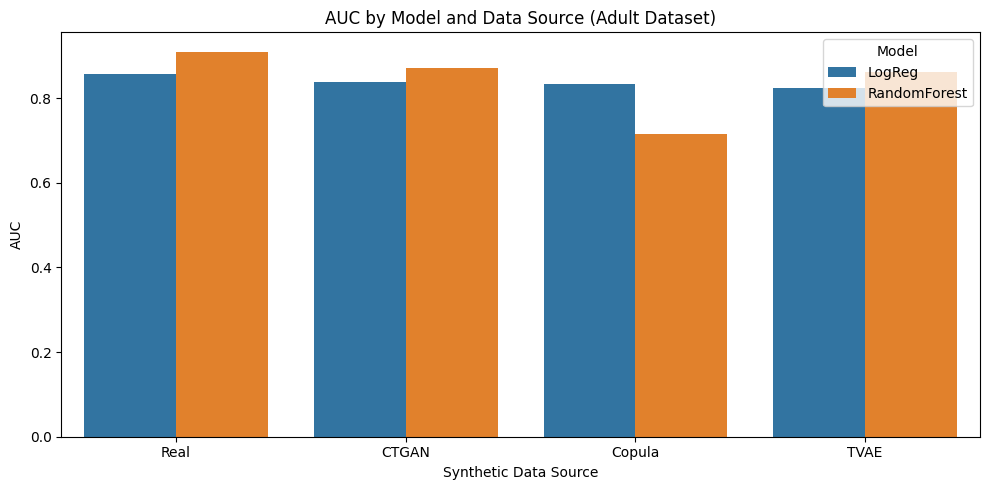

In [11]:
#plot results with barplot

import seaborn as sns

for metric in ["Accuracy", "F1", "AUC"]:
    plt.figure(figsize=(10, 5))
    sns.barplot(data=results_df, x="Trained_On", y=metric, hue="Model")
    plt.title(f"{metric} by Model and Data Source (Adult Dataset)")
    plt.ylabel(metric)
    plt.xlabel("Synthetic Data Source")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"utility_{metric.lower()}_by_model.png"))
    plt.show()
